In [1]:
import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
from fastai.layers import Lambda
from fastai.callbacks import SaveModelCallback
import pytorch_ssim as ssim
from superres import *

In [2]:
def icnr(x, scale, init=nn.init.kaiming_normal_):
    new_shape = [int(x.shape[0] / (scale ** 2))] + list(x.shape[1:])
    subkernel = torch.zeros(new_shape)
    subkernel = init(subkernel)
    subkernel = subkernel.transpose(0, 1)
    subkernel = subkernel.contiguous().view(subkernel.shape[0],
                                            subkernel.shape[1], -1)
    kernel = subkernel.repeat(1, 1, scale ** 2)
    transposed_shape = [x.shape[1]] + [x.shape[0]] + list(x.shape[2:])
    kernel = kernel.contiguous().view(transposed_shape)
    kernel = kernel.transpose(0, 1)
    return kernel

In [3]:
class Block(nn.Module):
    def __init__(self, n_feats, kernel_size, wn, act=nn.ReLU(True), res_scale=1):
        super(Block, self).__init__()
        self.res_scale = res_scale
        body = []
        expand = 6
        linear = 0.8
        body.append(
            wn(nn.Conv2d(n_feats, n_feats*expand, 1, padding=1//2)))
        body.append(act)
        body.append(
            wn(nn.Conv2d(n_feats*expand, int(n_feats*linear), 1, padding=1//2)))
        body.append(
            wn(nn.Conv2d(int(n_feats*linear), n_feats, kernel_size, padding=kernel_size//2)))

        self.body = nn.Sequential(*body)

    def forward(self, x):
        res = self.body(x) * self.res_scale
        res += x
        return res

In [4]:
class ICNRUpsample(nn.Module):
    def __init__(self,nf_in, nf_out, kernel_size, scale, wn):
        super().__init__()
        conv_shuffle = nn.Conv2d(nf_in, nf_out, kernel_size, padding=kernel_size//2)
        kernel = icnr(conv_shuffle.weight, scale=scale)
        conv_shuffle.weight.data.copy_(kernel);
        self.features = nn.Sequential(*[wn(conv_shuffle), nn.PixelShuffle(scale)])
    
    def forward(self, x):
        return self.features(x)
        

In [5]:
class WDSR(nn.Module):
    def __init__(self, scale, n_resblocks, n_feats, res_scale, n_colors=3):
        super().__init__()
        # hyper-params
        kernel_size = 3
        act = nn.ReLU(True)
        # wn = lambda x: x
        wn = lambda x: torch.nn.utils.weight_norm(x)

        mean, std = [0.40], [0.50] # imagenet_stats
        self.rgb_mean = torch.FloatTensor(mean).view([1, n_colors, 1, 1])
        self.rgb_std = torch.FloatTensor(std).view([1, n_colors, 1, 1])

        # define head module
        head = []
        head.append(wn(nn.Conv2d(n_colors, n_feats,kernel_size,padding=kernel_size//2)))

        # define body module
        body = []
        for i in range(n_resblocks):
            body.append(
                Block(n_feats, kernel_size, act=act, res_scale=res_scale, wn=wn))

        # define tail module
        tail = []
        out_feats = scale*scale*n_colors
        tail.append(ICNRUpsample(n_feats, out_feats, kernel_size, scale, wn))

        skip = []
        skip.append(ICNRUpsample(n_colors, out_feats, 5, scale, wn))

        pad = []
        pad.append(torch.nn.ReplicationPad2d(5//2))

        # make object members
        self.head = nn.Sequential(*head)
        self.body = nn.Sequential(*body)
        self.tail = nn.Sequential(*tail)
        self.skip = nn.Sequential(*skip)
        self.pad = nn.Sequential(*pad)

    def forward(self, x):
        mean = self.rgb_mean.to(x)
        std = self.rgb_std.to(x)
        
        x = (x - mean) / std
        #if not self.training: 
        #    x = self.pad(x)
        
        s = self.skip(x)
        x = self.head(x)
        x = self.body(x)
        x = self.tail(x)
        x += s
        x = x*std + mean
        return x

In [6]:
ssim_loss = ssim.SSIM(mult=-1.)
ssim_loss_2 = ssim.SSIM(window_size=3, mult=-1.)
ssim_loss_3 = ssim.SSIM(window_size=32, mult=-1.)

def fft_loss(pred, targs):
    bs = pred.shape[0]
    pred_fft = torch.rfft(pred, 2)
    targs_fft = torch.rfft(targs,2)
    return F.mse_loss(pred_fft.view(bs,-1), targs_fft.view(bs,-1))

def combo_loss(pred, targs):
    return (3 + 
            ssim_loss(pred,targs) + 
            ssim_loss_2(pred,targs) + 
            ssim_loss_3(pred,targs) + 
            F.mse_loss(pred, targs)
           )
    #return ssim_loss(pred, targs) + psnr_loss(pred, targs)/50. # + F.l1_loss(pred, targs)

def combo_loss(pred, targs):
    #pred_clamp = torch.clamp(pred,0.,1.)
    pred_clamp = pred
    return (1 + 
            ssim_loss(pred_clamp,targs) + 
            #ssim_loss_2(pred_clamp,targs) + 
            #ssim_loss_3(pred_clamp,targs) + 
            F.mse_loss(pred, targs)
           )
  
metrics = [F.mse_loss, 
           ssim.ssim,
           psnr]

In [7]:
path = Path('/DATA/WAMRI/SALK/uri/Image_restoration_data/')
train_lr = path/'train_LR'
train_hr = path/'train_HR'
test_lr = path/'test_LR'
test_hr = path/'test_HR'

In [8]:
def pull_id(fn):
    return fn.split('#')[-1].split('.')[0]

def match_hr_fn(x):
    return hr_names_by_id[pull_id(x.name)]

lr_names_full = list(train_lr.glob('*.tif'))
lr_names_full.sort()
hr_names_by_id = {pull_id(hrfn.name):hrfn for hrfn in train_hr.glob('*.tif')}
test_label = list(hr_names_by_id.values())[0]

In [9]:
class GrayImageItemList(ImageItemList):
    def open(self, fn): return open_grayscale(fn)

src = (GrayImageItemList
       .from_folder(train_lr, '*.tif', label_class=GrayImageItemList)
       .split_by_valid_func(lambda x: x.stem[-3] == '0')
       .label_from_func(match_hr_fn))

In [10]:
def get_data(src, bs, sz_lr, sz_hr, num_workers=12, test_folder=None, **kwargs):
    tfms = get_transforms(flip_vert=True)
    src = src.transform(tfms, size=sz_lr).transform_labels(size=sz_hr)
    if test_folder:
        src = src.add_test_folder(test_folder, label=test_label)
    data = src.databunch(bs=bs, num_workers=num_workers, **kwargs)
    return data

In [11]:
scale=4
n_resblocks=16
n_feats=128
res_scale= 1.
model = WDSR(scale, n_resblocks, n_feats, res_scale, n_colors=1)
model = nn.DataParallel(model).eval().cuda()

In [12]:
sz_lr = 72
scale,bs = 4,24
sz_hr = sz_lr*scale
data = get_data(src, bs, sz_lr, sz_hr)

In [13]:
data.train_ds[0]

(Image (1, 72, 72), Image (1, 288, 288))

In [14]:
loss = F.mse_loss
#loss=ssim_loss
learn = Learner(data, model, loss_func=loss, metrics=metrics)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


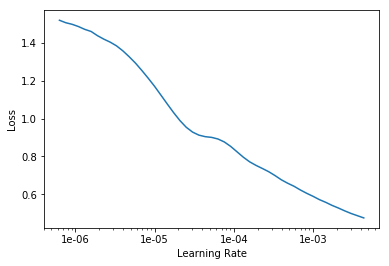

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr = 1e-3
learn.fit_one_cycle(30, lr)

Total time: 06:05
epoch  train_loss  valid_loss  mse_loss  ssim  psnr          
1      0.242780    0.106901    0.106901  -0.015100  9.710192   (00:11)
2      0.122263    0.015139    0.015139  -0.090985  18.199018  (00:11)
3      0.072214    0.011927    0.011927  0.228805  19.234827   (00:11)
4      0.047422    0.008662    0.008662  0.130155  20.623625   (00:12)
5      0.033533    0.008297    0.008297  0.618202  20.810612   (00:12)
6      0.025128    0.007952    0.007952  0.597746  20.995142   (00:12)
7      0.019891    0.007898    0.007898  0.521898  21.024620   (00:12)
8      0.016459    0.008100    0.008100  0.633774  20.914957   (00:12)
9      0.014147    0.007876    0.007876  0.663469  21.036741   (00:12)
10     0.012635    0.008142    0.008142  0.133015  20.892422   (00:11)
11     0.011712    0.007855    0.007855  0.616312  21.048714   (00:12)
12     0.010993    0.007797    0.007797  0.668453  21.080923   (00:12)
13     0.010506    0.007678    0.007678  0.674366  21.147263   (00:1

In [ ]:
learn.save('wdsr')

In [ ]:
sz_lr = 506
scale,bs = 4,1
sz_hr = sz_lr*scale
data = get_data(src, bs, sz_lr, sz_hr)
learn = Learner(data, model, loss_func=F.mse_loss)
preds, ys = learn.get_preds(DatasetType.Valid)
preds = torch.clamp(preds, 0.,1.)

In [ ]:
idx = 9
ys[idx].std(), preds[idx].std()

In [ ]:
preds[idx].min(),preds[idx].max()

In [ ]:
hr = Image(ys[idx])
hr

In [ ]:
sr = Image(preds[idx])
sr

In [ ]:
lr = learn.data.valid_ds[idx][0]
lr

In [ ]:
ssim.ssim(sr.data[None],hr.data[None]), psnr(sr.data[None],hr.data[None]), F.mse_loss(sr.data[None],hr.data[None])

In [ ]:
learn.save('wdsr')

In [ ]:
learn = learn.load('wdsr')

In [ ]:
trn_tfm, val_tfm = get_transforms()
test_bs = 2
test_sz = 512 
test_out_sz = 4*test_sz
test_data = get_data(src, test_bs, test_sz, test_out_sz, test_folder=path/'lores2')
test_learn = Learner(test_data, model, loss_func=F.mse_loss).load('wdsr')

In [ ]:
test_preds, ys = test_learn.get_preds(DatasetType.Test)
test_preds = torch.clamp(test_preds, 0.,1.)

In [ ]:
sr_imgs = []
for idx in range(test_preds.shape[0]):
    img = Image(test_preds[idx])
    sr_imgs.append(img)

In [ ]:
sr_imgs[1]